# Counting Scales

In [53]:
%pylab inline

import cv2
import seaborn
import pandas

Populating the interactive namespace from numpy and matplotlib


In [2]:
def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of 
    each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of 
             each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    
    From : http://stackoverflow.com/questions/32328179/opencv-3-0-python-lineiterator
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]
    
    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)
    
    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)
    
    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
            itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
            itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
            itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
            itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32)/dY.astype(np.float32)
            if negY:
                itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
            else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
            itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32)/dX.astype(np.float32)
            if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
            else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
            itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]
    
    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]
    
    return itbuffer

In [111]:
upsampled = len( point_values ) / float(20000)

def peaks_to_dataframe( peaks, point_values, upsampled=upsampled ) :

    data = []
    peak_coords = map( lambda i : int( i * upsampled ), peaks )
    for p1,p2 in zip( peak_coords, peak_coords[1:] ) :
        x1,y1,v1 = point_values[p1,:]
        x2,y2,v2 = point_values[p2,:]
        data.append( { 'X' : int(x1),
                       'Y' : int(y1),
                       'V' : int(v1),
                       'gap' : ((x2-x1)**2 + (y2-y1)**2)**0.5 } )
    
    df = pandas.DataFrame( data, columns=['X','Y','V','gap'] )
    df.index.name = 'peak'
    return df

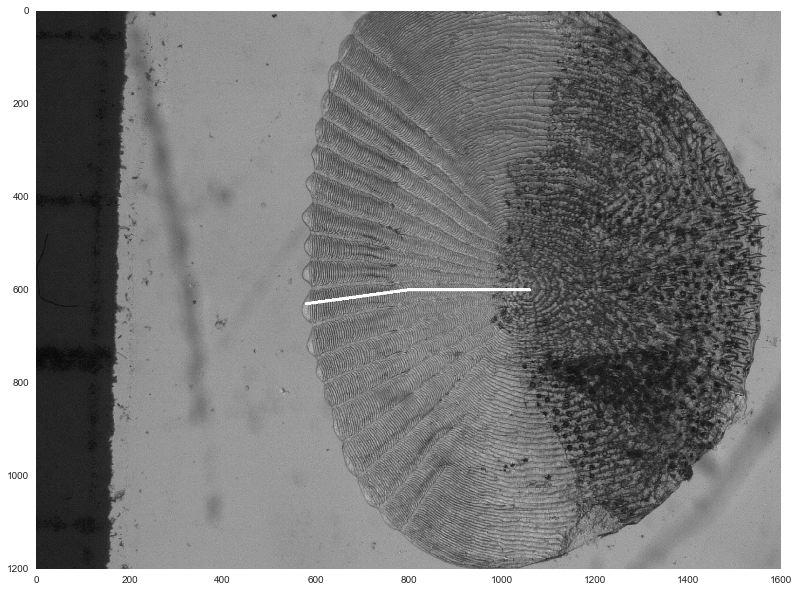

In [112]:
points = [ (580,630), (800,600), (1060,600) ]
filename = 'scale.tif'

figure( figsize=(16,10) )

img = cv2.imread( filename )
img = cv2.cvtColor( img, cv2.COLOR_BGR2GRAY) #change to grayscale

point_values = array( [[-1,-1,-1]] )

for p1, p2 in zip( points, points[1:] ) :
    point_values = append( point_values, createLineIterator( array(p1), array(p2),  img ), axis=0 )

point_values = point_values[1:]
    
for p1, p2 in zip( points, points[1:] ) :
    cv2.line( img, p1, p2, (255,255,255), 5 )

grid( False )
imshow( img, 'gray' )

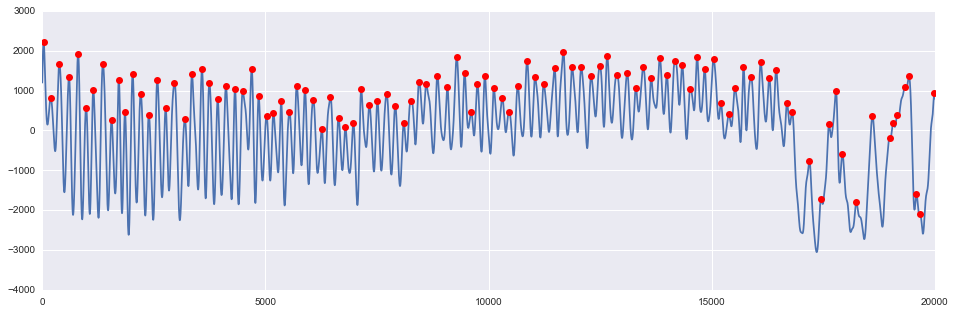

In [113]:
from scipy.signal import resample, detrend, gaussian

plt.figure( figsize=(16,5) )

rpv = convolve( detrend( resample( point_values[:,2], 20000 ) ), gaussian( 100, 20 ), mode='same' )

plot( rpv )

peaks = []
for i,(p1,p2,p3) in enumerate(zip( rpv, rpv[1:], rpv[2:] )) :
    if p1 < p2 and p2 > p3 :
        peaks.append(i)
        plot( i, rpv[i], 'ro' )

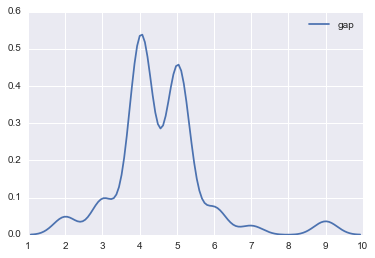

In [115]:
df = peaks_to_dataframe( peaks, point_values )
df.to_csv( filename.split('.')[0] + '_peaks.csv' )

seaborn.kdeplot( df['gap'] )

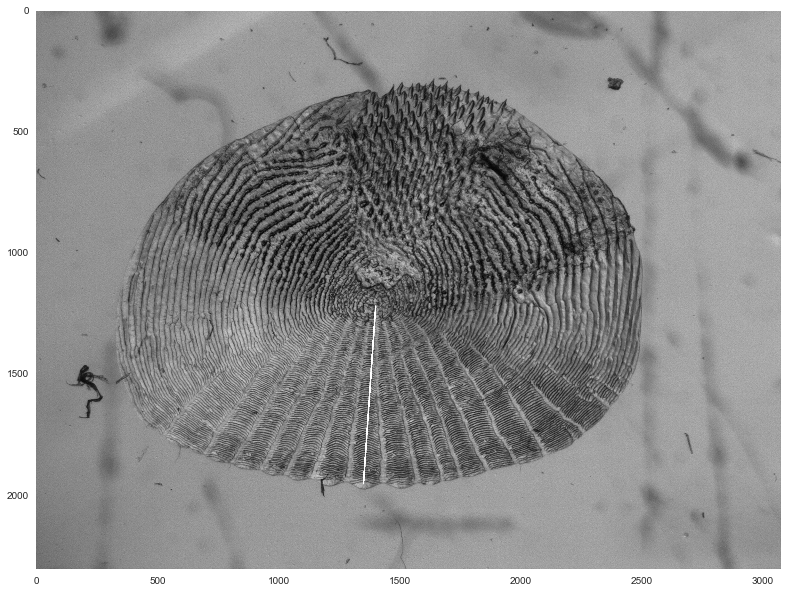

In [117]:
points = [ (1350,1950), (1400,1220) ]
filename = 'Astatoreochromis_alluaudi.jpg'

figure( figsize=(16,10) )

scaleimg = cv2.imread( filename )
scaleimg = cv2.cvtColor( scaleimg, cv2.COLOR_BGR2GRAY) #change to grayscale

point_values = array( [[-1,-1,-1]] )

for p1, p2 in zip( points, points[1:] ) :
    point_values = append( point_values, createLineIterator( array(p1), array(p2),  scaleimg ), axis=0 )

point_values = point_values[1:]
    
for p1, p2 in zip( points, points[1:] ) :
    cv2.line( scaleimg, p1, p2, (255,255,255), 5 )

grid( False )
imshow( scaleimg, 'gray' )

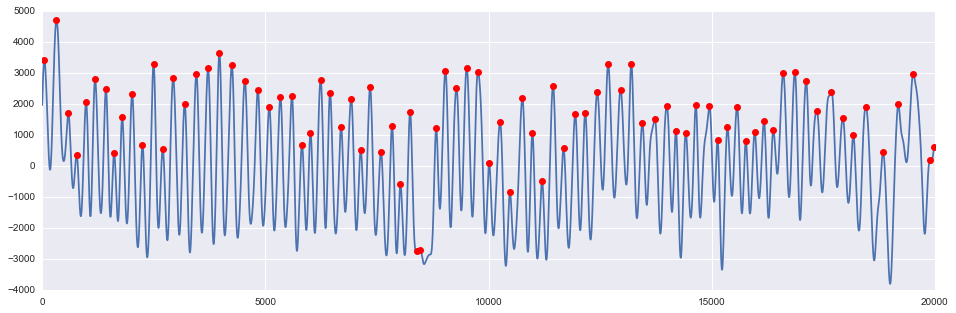

In [118]:
from scipy.signal import resample, detrend, gaussian

plt.figure( figsize=(16,5) )

rpv = convolve( detrend( resample( point_values[:,2], 20000 ) ), gaussian( 120, 30 ), mode='same' )

plot( rpv )

peaks = []
for i,(p1,p2,p3) in enumerate(zip( rpv, rpv[1:], rpv[2:] )) :
    if p1 < p2 and p2 > p3 :
        peaks.append(i)
        plot( i, rpv[i], 'ro' )

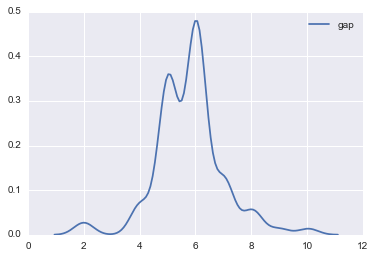

In [119]:
df = peaks_to_dataframe( peaks, point_values )
df.to_csv( filename.split('.')[0] + '_peaks.csv' )

seaborn.kdeplot( df['gap'] )

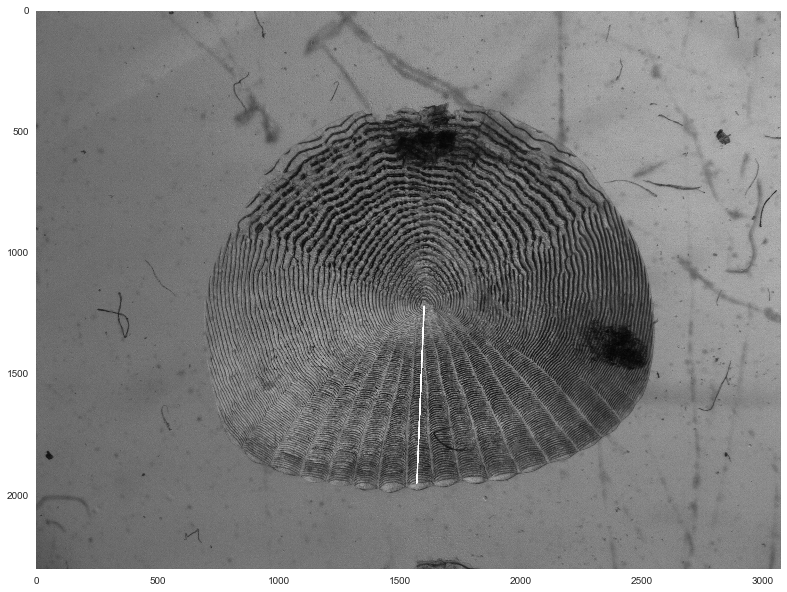

In [120]:
points = [ (1570,1950), (1600,1220) ]
filename = 'Oreochromis.jpg'

figure( figsize=(16,10) )

scaleimg = cv2.imread( filename )
scaleimg = cv2.cvtColor( scaleimg, cv2.COLOR_BGR2GRAY) #change to grayscale

point_values = array( [[-1,-1,-1]] )

for p1, p2 in zip( points, points[1:] ) :
    point_values = append( point_values, createLineIterator( array(p1), array(p2),  scaleimg ), axis=0 )

point_values = point_values[1:]
    
for p1, p2 in zip( points, points[1:] ) :
    cv2.line( scaleimg, p1, p2, (255,255,255), 5 )

grid( False )
imshow( scaleimg, 'gray' )

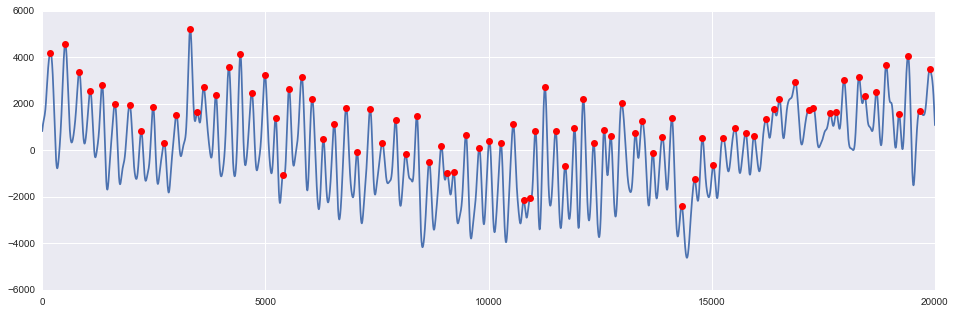

In [121]:
from scipy.signal import resample, detrend, gaussian

plt.figure( figsize=(16,5) )

rpv = convolve( detrend( resample( point_values[:,2], 20000 ) ), gaussian( 120, 30 ), mode='same' )

plot( rpv )

peaks = []
for i,(p1,p2,p3) in enumerate(zip( rpv, rpv[1:], rpv[2:] )) :
    if p1 < p2 and p2 > p3 :
        peaks.append(i)
        plot( i, rpv[i], 'ro' )

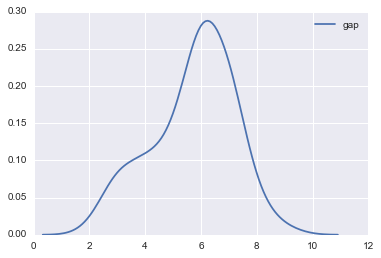

In [122]:
df = peaks_to_dataframe( peaks, point_values )
df.to_csv( filename.split('.')[0] + '_peaks.csv' )

seaborn.kdeplot( df['gap'] )